<a href="https://colab.research.google.com/github/baalasangar/MLAI/blob/master/13_Capstone/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pydicom
# !pip install -U pip
# !pip install -U setuptools wheel
# !pip install -U "mxnet<2.0.0"
# !pip install autogluon

### Import lib

In [1]:
import pandas as pd 
import numpy as np
import os
import pydicom as dicom
import cv2
import shutil

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import autogluon.core as ag
from autogluon.vision import ObjectDetector

import tensorflow as tf
from tensorflow.keras.models import load_model

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.9.0+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


### load model

In [3]:
OBJECT_DETECTION =  '/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/model/detector_autog_v1.pkl'
CLASSIFICATION = "/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/model/resnet152_model.h5"

model = tf.keras.models.load_model(CLASSIFICATION)
object_detector = ObjectDetector.load(OBJECT_DETECTION)



100%|██████████| 57421/57421 [00:01<00:00, 29742.43KB/s]
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:1591: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


### load predict data

In [4]:
# predict_data = pd.read_csv("/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/predict.csv")
# predict_data.head()

,image,rois,image_attr
0,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.15625, 'ymin': 0.179...","{'width': 128.0, 'height': 128.0}"
1,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.5546875, 'ymin': 0.3...","{'width': 128.0, 'height': 128.0}"
2,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.1875, 'ymin': 0.2187...","{'width': 128.0, 'height': 128.0}"
3,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.6171875, 'ymin': 0.7...","{'width': 128.0, 'height': 128.0}"
4,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.2265625, 'ymin': 0.2...","{'width': 128.0, 'height': 128.0}"


In [32]:
predict_data = ObjectDetector.Dataset.from_voc("/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/autogluon/pheno_VOC", splits='test')

predict_data_df = predict_data[10:20]
predict_data_df

,image,rois,image_attr
10,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.15625, 'ymin': 0.179...","{'width': 128.0, 'height': 128.0}"
11,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.5546875, 'ymin': 0.3...","{'width': 128.0, 'height': 128.0}"
12,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.1875, 'ymin': 0.2187...","{'width': 128.0, 'height': 128.0}"
13,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.6171875, 'ymin': 0.7...","{'width': 128.0, 'height': 128.0}"
14,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.2265625, 'ymin': 0.2...","{'width': 128.0, 'height': 128.0}"
15,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.6484375, 'ymin': 0.2...","{'width': 128.0, 'height': 128.0}"
16,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.140625, 'ymin': 0.21...","{'width': 128.0, 'height': 128.0}"
17,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.703125, 'ymin': 0.30...","{'width': 128.0, 'height': 128.0}"
18,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.4765625, 'ymin': 0.3...","{'width': 128.0, 'height': 128.0}"
19,/content/drive/MyDrive/GreatLearning/Captone_p...,"[{'class': '0', 'xmin': 0.5859375, 'ymin': 0.5...","{'width': 128.0, 'height': 128.0}"


In [38]:
def CLAHEprocessing(img):
  clahe = cv2.createCLAHE(clipLimit = 5)
  clahe_img = clahe.apply(img) + 30
  return clahe_img

def predict_classification_score(dcm_image_pix):
    X_image_reshaped = [cv2.resize(img,(150,150)) for img in [dcm_image_pix]]
    normalizeimg = lambda x: (np.array(x) / 255.0).astype('float32')
    X_image_reshaped = normalizeimg(X_image_reshaped)
    # X_image_reshaped = np.repeat(X_image_reshaped[..., np.newaxis], 3, -1)
    predicted = model.predict(X_image_reshaped)
    return int(round(predicted[0][0]*100,0))


def predict_boundary_box(model,imagepath,imgcv):
  result = model.predict(imagepath)
  result = result.query("predict_score >= 0.5") 
  #result = result[:3]
  for index,predictrow in result.iterrows():
    predictedVal = predictrow["predict_rois"]
    # print(predictrow["predict_score"])
    cv2.rectangle(imgcv, (int(predictedVal["xmin"] * 128),int(predictedVal["ymin"] * 128)),
                  (int(predictedVal["xmax"] * 128),int(predictedVal["ymax"] * 128)), (0,255,0), 1)
    cv2.putText(imgcv,str(round(predictrow["predict_score"],2)),
                (int(predictedVal["xmin"] * 128),int(predictedVal["ymin"] * 128)), 0,0.3, (0, 255, 0))
  return imgcv        

   
def draw_boundary_box(row):
  imgcv = cv2.imread(row["image"])
  imgcv = predict_boundary_box(object_detector,row["image"],imgcv)
  # print(row)
  for trueVal in row["rois"]:
    # print(trueVal)
    cv2.rectangle(imgcv, (int(trueVal["xmin"] * 128),int(trueVal["ymin"] * 128)),
                  (int(trueVal["xmax"] * 128),int(trueVal["ymax"] * 128)), (255,0,0), 1)
    
  plt.imshow(imgcv,"bone") 
  plt.axis('off')
  plt.show()


In [41]:
def predict(row):
      imgcv = cv2.imread(row["image"])
      img_enhanced = imgcv
      prediction_score = predict_classification_score(img_enhanced)
      infected = "NOT Affected"
      if prediction_score > 50:
        infected = "Affected"  
        fontcolor = "red"
      else:
        prediction_score = 100 - prediction_score
      print("{} ( probability score {} %) \n".format(infected,prediction_score))
      # print(list(row["rois"]))
      draw_boundary_box(row)

Affected ( probability score 74 %) 



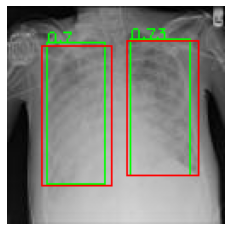


 

Affected ( probability score 76 %) 



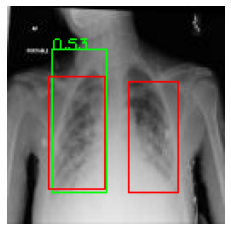


 

Affected ( probability score 74 %) 



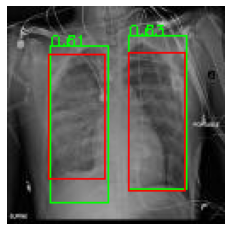


 

Affected ( probability score 77 %) 



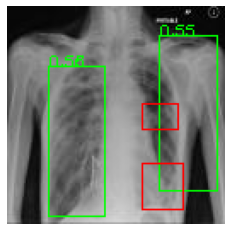


 

Affected ( probability score 74 %) 



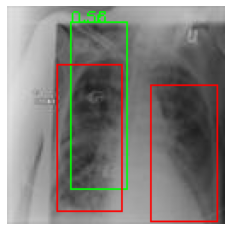


 

Affected ( probability score 70 %) 



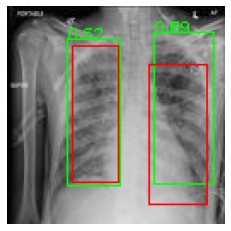


 

Affected ( probability score 72 %) 



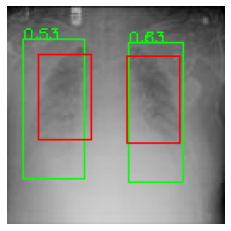


 

Affected ( probability score 69 %) 



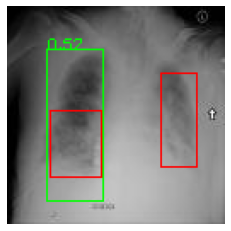


 

Affected ( probability score 74 %) 



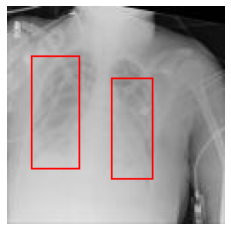


 

Affected ( probability score 66 %) 



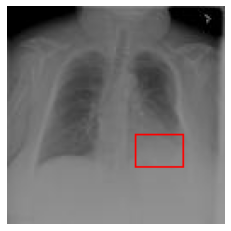

In [42]:
for index,row in predict_data_df.iterrows():  
  #print(imgcv.shape)
  predict(row)
  print("\n \n")